In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from eval_util import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering,convert_type
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline

In [34]:
dataname = "adult"
datapath = "dataset"
generated = "{}/generated/{}/".format(datapath,dataname)

data_origin = pd.read_csv("{}/origin/{}.csv".format(datapath,dataname))

#datalist = ["ctgan","tablegan","octgan","VAE","KL_daisy","sel_daisy","sm_daisy","selgan"]


ctgan = pd.read_csv("{}/generated/{}/ctgan/ctgan_less_300.csv".format(datapath,dataname))

if (dataname =="adult") or  (dataname =="credit"):
    tablegan = pd.read_csv("{}/generated/{}/tablegan/tablegan_{}_fake.csv".format(datapath,dataname,dataname))

if not dataname == "ticket":
    octgan = pd.read_csv("{}/generated/{}/octgan/octgan_{}.csv".format(datapath,dataname,dataname))
    
VAE = pd.read_csv("{}/generated/{}/VAE/sample_data_vae_800_0.csv".format(datapath,dataname,dataname)).set_axis(data_origin.columns, axis=1, inplace=False)
KL_daisy = pd.read_csv("{}/generated/{}/KL/KL_1_800_0.csv".format(datapath,dataname,dataname))

selgan = pd.read_csv("{}/generated/{}/selgan/selgan_300_less_batch.csv".format(datapath,dataname))
sel_daisy = pd.read_csv("{}/generated/{}/sel/sel_1_800_0.csv".format(datapath,dataname,dataname))
sm_daisy = pd.read_csv("{}/generated/{}/sel_mean/sel_mean_1_800_0.csv".format(datapath,dataname,dataname))



In [24]:
data_origin.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [40]:
data_origin

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
2,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30143,25,Private,350977,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K
30144,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
30145,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
30146,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [45]:
tablegan

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,23.0,Federal-gov,13769.0,7th-8th,16.0,Divorced,Exec-managerial,Husband,White,Female,0.0,0.0,1.0,Yugoslavia
1,30.0,Private,120029.0,11th,8.0,Married-civ-spouse,Farming-fishing,Other-relative,White,Male,8614.0,2754.0,49.0,Vietnam
2,30.0,Private,79036.0,1st-4th,8.0,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,1848.0,0.0,31.0,Vietnam
3,30.0,Private,72630.0,1st-4th,8.0,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,1506.0,0.0,27.0,Vietnam
4,30.0,Private,96586.0,12th,8.0,Married-spouse-absent,Handlers-cleaners,Own-child,White,Male,2228.0,0.0,35.0,Vietnam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,26.0,Private,157831.0,12th,8.0,Married-spouse-absent,Farming-fishing,Other-relative,White,Male,2580.0,0.0,50.0,Vietnam
29996,34.0,Private,97562.0,12th,10.0,Married-civ-spouse,Craft-repair,Unmarried,White,Female,594.0,0.0,42.0,Vietnam
29997,29.0,Private,126173.0,12th,9.0,Married-civ-spouse,Farming-fishing,Other-relative,White,Male,3325.0,0.0,54.0,Vietnam
29998,31.0,Private,128699.0,11th,9.0,Married-civ-spouse,Farming-fishing,Other-relative,White,Male,3674.0,0.0,53.0,Vietnam


## Visualization

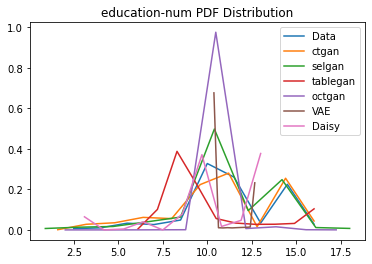

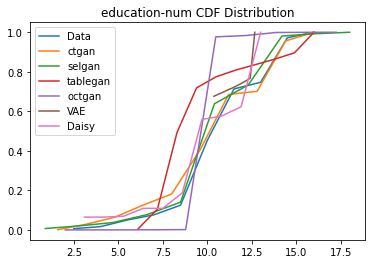

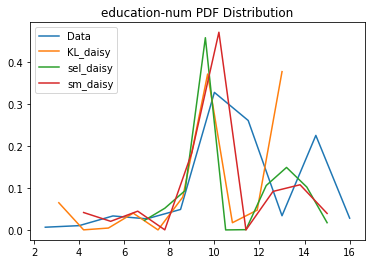

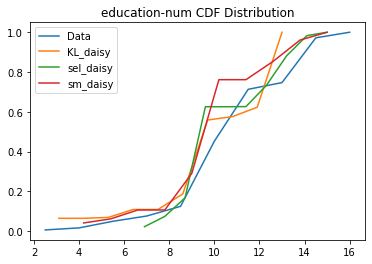

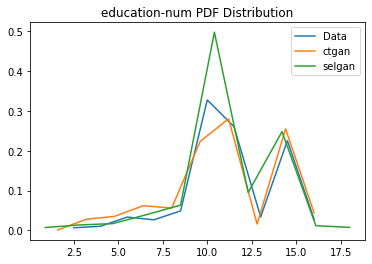

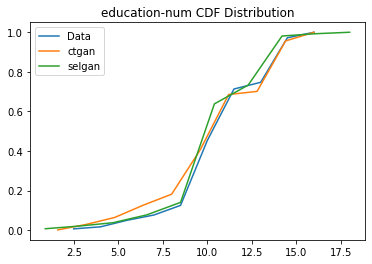

In [42]:
# CDF 可以用
column_name = "education-num"

make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_pdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_cdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],"education-num",
plot_cdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan],"education-num",
plot_cdf,["Data", "ctgan", "selgan"],"{} CDF Distribution".format(column_name))



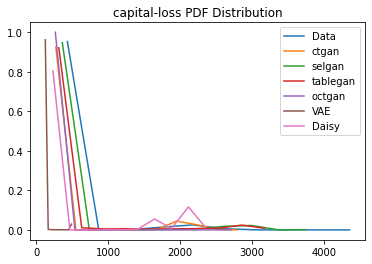

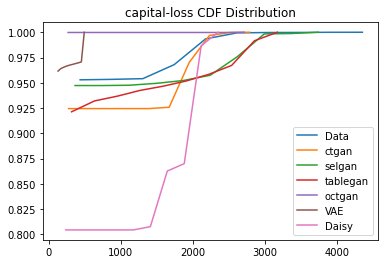

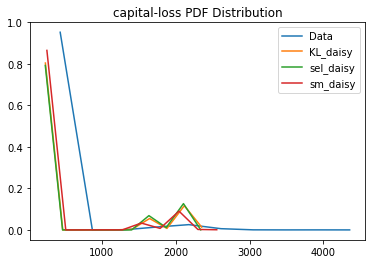

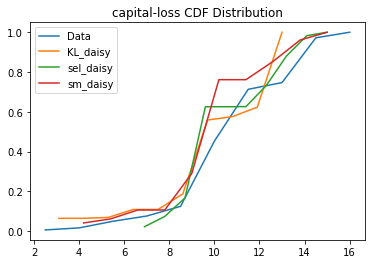

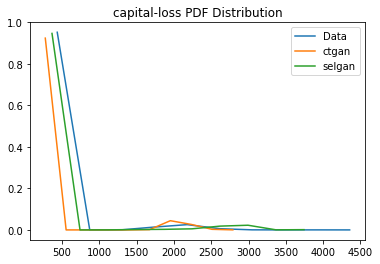

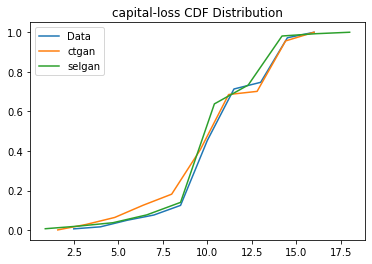

In [43]:
# 可以用
column_name = "capital-loss"

make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_pdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_cdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],"education-num",
plot_cdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan],"education-num",
plot_cdf,["Data", "ctgan", "selgan"],"{} CDF Distribution".format(column_name))

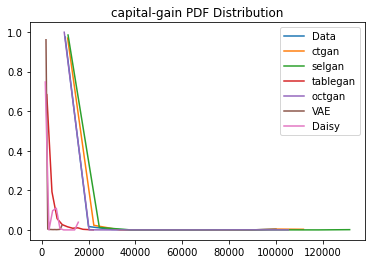

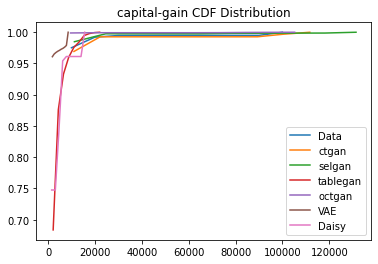

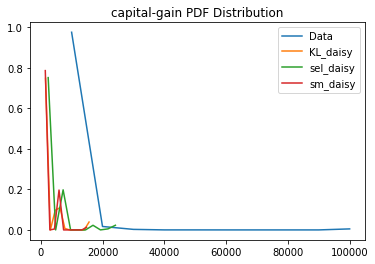

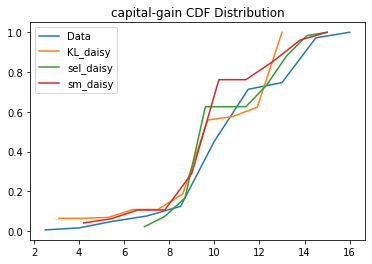

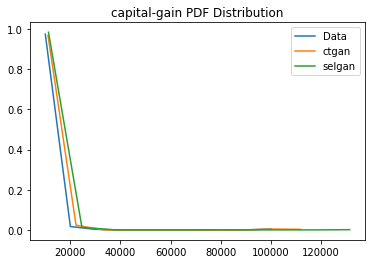

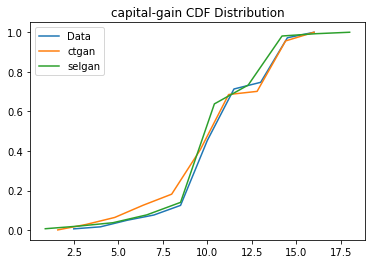

In [44]:
# 可以用
column_name = "capital-gain"

make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_pdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_cdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],"education-num",
plot_cdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan],"education-num",
plot_cdf,["Data", "ctgan", "selgan"],"{} CDF Distribution".format(column_name))

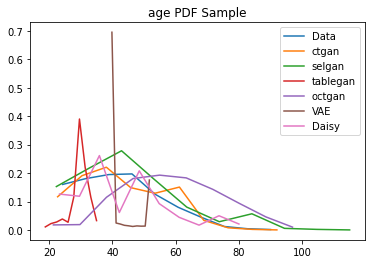

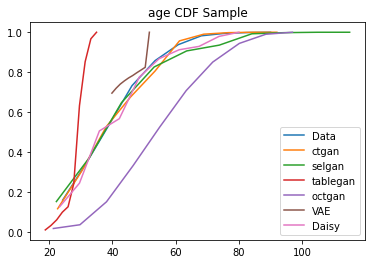

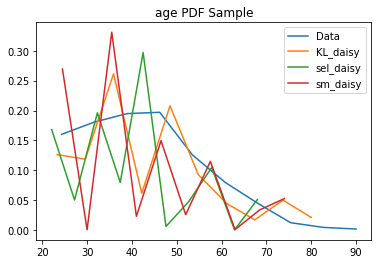

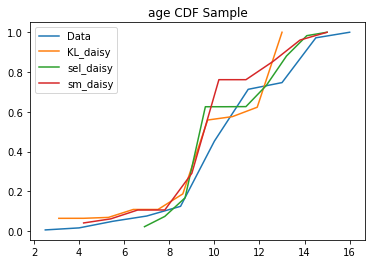

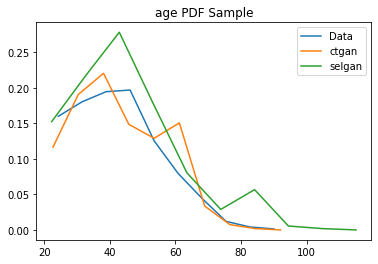

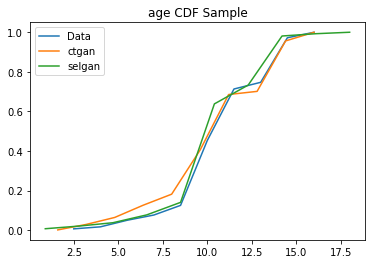

In [41]:
column_name = "age"

make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_pdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan, tablegan, octgan, VAE, KL_daisy],column_name,
plot_cdf,["Data", "ctgan", "selgan", "tablegan", "octgan", "VAE", "Daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, KL_daisy, sel_daisy, sm_daisy ],"education-num",
plot_cdf,["Data", "KL_daisy", "sel_daisy", "sm_daisy"],"{} CDF Distribution".format(column_name))

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name))
make_compare_plot([data_origin, ctgan, selgan],"education-num",
plot_cdf,["Data", "ctgan", "selgan"],"{} CDF Distribution".format(column_name))

In [132]:
data_origin.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'label'],
      dtype='object')

In [139]:
#Distance between NMI matrices
dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]

distance_NMI = {}

from sklearn.metrics.cluster import normalized_mutual_info_score
for col in ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country']:
    
    mylist = []
    for data in dataset:
        A = data_origin[col].sample(n=5000, random_state=1)
        B = data[col].sample(n=5000, random_state=1)
        mylist.append(normalized_mutual_info_score(A,B))
    distance_NMI[col] = mylist
        

In [142]:
distance_NMI_df = pd.DataFrame(distance_NMI,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
distance_NMI_df

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
ground Truth,0.003540,0.010454,0.002205,0.007153,0.001448,0.003187,0.000612,0.037625
ctgan,0.002171,0.009743,0.002014,0.009054,0.001554,0.002922,0.000008,0.037840
selgan,0.002910,0.009771,0.002674,0.007039,0.001365,0.003024,0.000299,0.048049
octgan,0.001300,0.005047,0.001452,0.004442,0.001993,0.003156,0.000125,0.037881
VAE,0.000000,0.002744,0.001939,0.003561,0.001702,0.000000,0.000010,0.000000
KL_daisy,0.003644,0.008397,0.002860,0.007776,0.002448,0.002655,0.000051,0.024968
sel_daisy,0.002450,0.010305,0.001218,0.004445,0.001074,0.001095,0.000034,0.016275
sm_daisy,0.002194,0.007941,0.003495,0.006560,0.002009,0.002974,0.000031,0.016718


In [148]:
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [162]:
VAE = VAE.dropna()

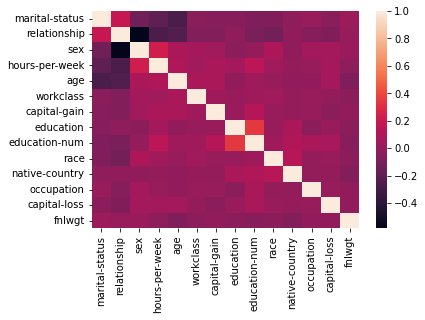

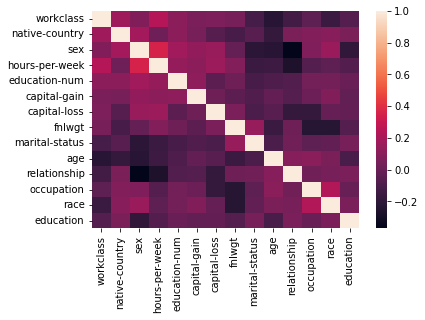

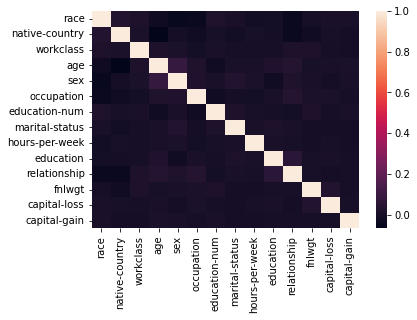

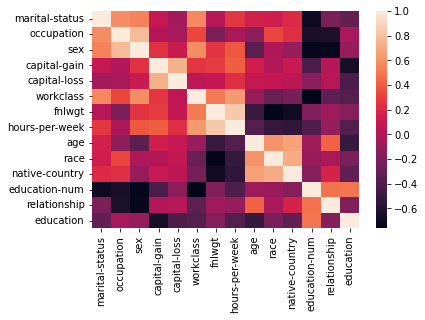

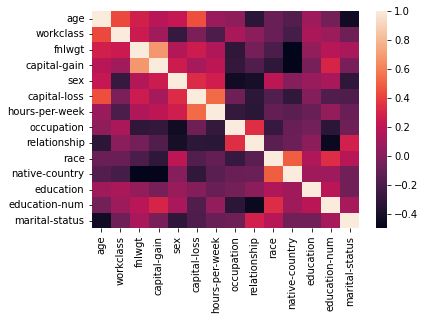

In [173]:
sns.heatmap(cluster_corr(data_origin.corr()))
plt.show()
sns.heatmap(cluster_corr(selgan.corr()))
plt.show()
sns.heatmap(cluster_corr(octgan.corr()))
plt.show()
sns.heatmap(cluster_corr(tablegan.corr()))
plt.show()
sns.heatmap(cluster_corr(KL_daisy.corr()))
plt.show()

## Evaluation

#### Convert data type

In [35]:
import json

with open(datapath +"/configeration/" +dataname+"_config.json", 'r') as f:
    config = json.load(f)

In [36]:
categoricals = config["one-hot_cols"]
ordinals = config["ordinal_cols"]

#coverted_train = convert_type(train, categoricals+ordinals)

In [37]:
#sorted(categoricals+ordinals)

In [38]:
# tablegan没有income 所以不参加

data_origin["label"] = "data"


ctgan["label"] = "ctgan"
selgan["label"] = "selgan"
octgan["label"] = "octgan"
tablegan["label"] = "tablegan"
VAE["label"] = "VAE"
KL_daisy["label"] = "KL"
sel_daisy["label"] = "sel"
sm_daisy["label"] = "sm"



In [39]:
full = pd.concat([data_origin,ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy])
full = full[data_origin.columns]
full = convert_type(full,sorted(categoricals+ordinals))

my col_list [1, 3, 5, 6, 7, 8, 9, 13]


In [40]:

data_origin = full[full["label"] == "data"]
ctgan = full[full["label"] == "ctgan"]
selgan = full[full["label"] == "selgan"]
octgan = full[full["label"] == "octgan"]
tablegan = full[full["label"] == "tablegan"]
VAE = full[full["label"] == "VAE"]
KL_daisy = full[full["label"] == "KL"]
sel_daisy = full[full["label"] == "sel"]
sm_daisy = full[full["label"] == "sm"]




#### Split train and test

In [41]:
data_origin_droped = data_origin.drop(columns=["label","fnlwgt"]).astype("float64")
origin_np = np.array(data_origin_droped)
col = list(data_origin_droped.columns)
indices = numpy.random.permutation(data_origin.shape[0])
n = int(data_origin.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
#training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [42]:
sm_daisy

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,17.0,2.0,1.0,7.0,4.0,11.0,1.0,4.0,0.0,0.0,0.0,36.0,37.0,0.0
1,32.0,2.0,11.0,9.0,4.0,5.0,2.0,4.0,1.0,0.0,0.0,60.0,37.0,0.0
2,27.0,2.0,9.0,13.0,4.0,0.0,3.0,4.0,1.0,0.0,0.0,38.0,37.0,0.0
3,33.0,4.0,15.0,10.0,2.0,2.0,0.0,4.0,1.0,7298.0,0.0,56.0,37.0,1.0
4,49.0,2.0,5.0,4.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,40.0,37.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21099,22.0,2.0,15.0,10.0,4.0,12.0,1.0,4.0,0.0,0.0,0.0,43.0,37.0,0.0
21100,39.0,4.0,9.0,13.0,2.0,7.0,0.0,4.0,1.0,0.0,0.0,60.0,37.0,0.0
21101,18.0,4.0,1.0,7.0,4.0,7.0,3.0,4.0,0.0,0.0,0.0,4.0,37.0,0.0
21102,25.0,2.0,0.0,6.0,2.0,7.0,5.0,4.0,0.0,0.0,0.0,40.0,37.0,0.0


In [43]:

# distorsions = []
# for k in range(2, 20):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(range(2, 20), distorsions)
# plt.grid(True)

# plt.title('Elbow curve')
# plt.show()

In [44]:
from tqdm import tqdm

def make_prediction(response, response_type,training_data, test, dataset):

    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    if response_type == "clf":

        clf = xgb.XGBClassifier(eval_metric='mlogloss')

    else:

        clf = xgb.XGBRegressor(eval_metric='mlogloss')

    clf.fit(train_data_X, train_data_y)
    result.append(clf.score(test_data_X,test_data_y))


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label","fnlwgt"]).astype("float64")
        train_y = data[response].astype("float64")
        
        try:
            clf.fit(train_X, train_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)

    return result





# def make_prediction_diff(response, response_type,training_data, test,dataset):

#     result = []

#     train_data_y = training_data[response].astype("float64")
#     train_data_X = training_data.drop(columns=[response]).astype("float64")

#     test_data_X = test.drop(columns=[response]).astype("float64")
#     test_data_y = test[response].astype("float64")


#     if response_type == "clf":

#         clf = xgb.XGBClassifier(eval_metric='mlogloss')

#     else:

#         clf = xgb.XGBRegressor(eval_metric='mlogloss')

#     clf.fit(train_data_X, train_data_y)
#     ground_truth = clf.score(test_data_X,test_data_y)
#     result.append(abs(ground_truth - ground_truth))


#     for data in dataset:

#         train_X = data.drop(columns=[response,"label","fnlwgt","income"]).astype("float64")
#         train_y = data[response].astype("float64")
        
#         try:
#             clf.fit(train_X, train_y)
#             result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))
#         except:
#             result.append(np.nan)

#     return result

In [45]:
ctgan

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,33.0,2,216428.0,1,13.0,0,11,3,4,0,-5.0,1952.0,40.0,37,0,ctgan
1,38.0,2,170096.0,7,2.0,2,2,5,4,1,30.0,1.0,27.0,24,0,ctgan
2,35.0,2,278062.0,8,9.0,2,13,0,4,1,21.0,-3.0,45.0,28,0,ctgan
3,54.0,2,232774.0,14,14.0,2,0,0,4,1,14910.0,-1.0,40.0,37,1,ctgan
4,47.0,3,97725.0,12,11.0,2,3,5,4,1,-7.0,1.0,49.0,37,1,ctgan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30143,59.0,2,682994.0,10,14.0,2,3,0,3,1,15.0,1898.0,40.0,37,1,ctgan
30144,51.0,4,150127.0,9,13.0,4,12,1,2,0,-20.0,0.0,40.0,6,0,ctgan
30145,43.0,5,328807.0,8,14.0,2,9,1,4,1,9.0,0.0,36.0,37,1,ctgan
30146,38.0,2,48614.0,12,14.0,2,11,0,4,1,-11.0,1.0,66.0,37,1,ctgan


In [46]:
#dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]
dataset = [ctgan,selgan,octgan,VAE,KL_daisy,sel_daisy,sm_daisy]
#dataset = [ctgan]

In [129]:
prediction = {}
prediction["age"] = make_prediction("age", "reg",training_data, test, dataset)
prediction["workclass"] = make_prediction("workclass", "clf",training_data, test, dataset)
prediction["education"] = make_prediction("education", "clf",training_data, test, dataset)
prediction["education_num"] = make_prediction("education-num", "reg",training_data, test,dataset)
prediction["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction["native_country"] = make_prediction("native-country", "reg",training_data, test,dataset)
prediction["income"] = make_prediction("income", "clf",training_data, test,dataset)


In [51]:
# Adult work class, Occupation, relationship, sex 
# 结论：daisy + sel 会提升
# selgan: 没调参数，没ctgan好，但是还是比其他好

ML_result = pd.DataFrame(prediction,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])

In [54]:
#ML_result[["workclass","relationship","sex"]]
ML_result

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.444700,0.742702,1.000000,0.999812,0.846196,0.339120,0.792791,0.880031,0.850177,-0.131336,-0.019648,0.248897,0.092340,0.865104
ctgan,0.196704,0.728328,0.629589,0.362964,0.743919,0.231756,0.647612,0.853494,0.738943,-0.112143,-0.092303,0.117577,-0.361853,0.824746
selgan,0.102783,0.698585,0.413866,0.015821,0.701238,0.146285,0.546108,0.796661,0.685980,-0.205833,-0.192955,0.045898,-0.457865,0.774657
octgan,-0.864365,0.720035,0.033061,-0.018205,0.194051,0.112340,0.192282,0.476559,0.499115,-0.315654,-0.042590,-0.081179,-4.954730,0.743034
VAE,-0.171413,NaN,0.502543,0.075449,0.642304,0.274547,0.523109,NaN,0.728218,-0.131722,-0.151045,-0.047949,-0.068256,0.796218
KL_daisy,0.004348,0.677023,0.237063,0.011503,0.621849,0.102167,0.498120,0.815900,0.653804,-0.162306,-6.715485,-0.159331,-0.397473,0.761389
sel_daisy,-0.059749,0.719040,0.248673,-0.170717,0.582817,0.190402,0.511720,0.807607,0.714286,-0.785127,-4.089990,-0.265095,-0.496653,0.574856
sm_daisy,-0.381951,0.648828,0.271451,-0.322925,0.648828,0.141199,0.572645,0.818885,0.734962,-0.097659,-2.348037,-0.222211,-0.352507,0.749447


In [49]:
# prediction_diff = {}
# prediction_diff["age"] = make_prediction_diff("age", "reg",training_data, test,dataset)
# prediction_diff["workclass"] = make_prediction_diff("workclass", "clf",training_data, test,dataset)
# prediction_diff["education"] = make_prediction_diff("education", "clf",training_data, test,dataset)
# prediction_diff["education_num"] = make_prediction_diff("education-num", "reg",training_data, test,dataset)
# prediction_diff["marital_status"] = make_prediction_diff("marital-status", "clf",training_data, test,dataset)
# prediction_diff["occupation"] = make_prediction_diff("occupation", "clf",training_data, test,dataset)
# prediction_diff["relationship"] = make_prediction_diff("relationship", "clf",training_data, test,dataset)
# prediction_diff["race"] = make_prediction_diff("race", "clf",training_data, test,dataset)
# prediction_diff["sex"] = make_prediction_diff("sex", "clf",training_data, test,dataset)
# prediction_diff["capital_gain"] = make_prediction_diff("capital-gain", "reg",training_data, test,dataset)
# prediction_diff["capital_loss"] = make_prediction_diff("capital-loss", "reg",training_data, test,dataset)
# prediction_diff["hours_per_week"] = make_prediction_diff("hours-per-week", "reg",training_data, test,dataset)
# prediction_diff["native_country"] = make_prediction_diff("native-country", "clf",training_data, test,dataset)
# #prediction_diff["income"] = make_prediction_diff("income", "reg",training_data, test,dataset)
#pd.DataFrame(prediction,index=["ground Truth",'ctgan','selgan','octgan','tablegan','VAE','KL_daisy','sel_daisy','sm_daisy'])

its:7 col
full:7 col

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
def make_prediction_rf(response, response_type,training_data, test, dataset):

    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    if response_type == "clf":

        #clf = xgb.XGBClassifier(eval_metric='mlogloss')
        clf = RandomForestClassifier(random_state=0)

    else:

        clf = RandomForestRegressor(random_state=0)

    clf.fit(train_data_X, train_data_y)
    result.append(clf.score(test_data_X,test_data_y))


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label","fnlwgt"]).astype("float64")
        train_y = data[response].astype("float64")
        
        try:
            clf.fit(train_X, train_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)

    return result

In [ ]:
prediction_rf = {}
prediction_rf["age"] = make_prediction("age", "reg",training_data, test, dataset)
prediction_rf["workclass"] = make_prediction("workclass", "clf",training_data, test, dataset)
prediction_rf["education"] = make_prediction("education", "clf",training_data, test, dataset)
prediction_rf["education_num"] = make_prediction("education-num", "reg",training_data, test,dataset)
prediction_rf["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction_rf["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction_rf["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction_rf["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction_rf["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction_rf["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction_rf["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction_rf["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction_rf["native_country"] = make_prediction("native-country", "reg",training_data, test,dataset)
prediction_rf["income"] = make_prediction("income", "clf",training_data, test,dataset)

100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


In [128]:
ML_result_ref = pd.DataFrame(prediction_rf,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
ML_result_ref


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.444700,0.742702,1.000000,0.999812,0.846196,0.339120,0.792791,0.880031,0.850177,-0.131336,-0.019648,0.248897,0.092340,0.865104
ctgan,0.196704,0.728328,0.629589,0.362964,0.743919,0.231756,0.647612,0.853494,0.738943,-0.112143,-0.092303,0.117577,-0.361853,0.824746
selgan,0.102783,0.698585,0.413866,0.015821,0.701238,0.146285,0.546108,0.796661,0.685980,-0.205833,-0.192955,0.045898,-0.457865,0.774657
octgan,-0.864365,0.720035,0.033061,-0.018205,0.194051,0.112340,0.192282,0.476559,0.499115,-0.315654,-0.042590,-0.081179,-4.954730,0.743034
VAE,-0.171413,NaN,0.502543,0.075449,0.642304,0.274547,0.523109,NaN,0.728218,-0.131722,-0.151045,-0.047949,-0.068256,0.796218
KL_daisy,0.004348,0.677023,0.237063,0.011503,0.621849,0.102167,0.498120,0.815900,0.653804,-0.162306,-6.715485,-0.159331,-0.397473,0.761389
sel_daisy,-0.059749,0.719040,0.248673,-0.170717,0.582817,0.190402,0.511720,0.807607,0.714286,-0.785127,-4.089990,-0.265095,-0.496653,0.574856
sm_daisy,-0.381951,0.648828,0.271451,-0.322925,0.648828,0.141199,0.572645,0.818885,0.734962,-0.097659,-2.348037,-0.222211,-0.352507,0.749447


In [72]:
def make_clustering(training_data,test,dataset,n = 5):
    NMI = []

    train_data_x = training_data.drop(columns=["income"]).astype("float64")

    test_data_X = test.drop(columns=["income"]).astype("float64")
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))
    #print(train_data_x.columns)

    for data in dataset:
        data = data.drop(columns=["label","fnlwgt","income"]).astype("float64")
        #print(data.columns)
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI
### Clustering

In [73]:
## Unsupervised Machine learning task 

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
ctgan,0.822378
selgan,0.826309
octgan,0.638545
VAE,0.759005
KL_daisy,0.639846
sel_daisy,0.738263
sm_daisy,0.674454


## Loss 

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [ ]:
len(dataset)

In [ ]:
similar = hitting_rate(dataset)

In [ ]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])